In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.linear_model import LinearRegression

# np.set_printoptions(suppress=True) #, precision=3)

data = pd.read_csv('oregon-house-prices.csv')
data.head(10)

,House Size (ft²),Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900
5,1985,4,299900
6,1534,3,314900
7,1427,3,198999
8,1380,3,212000
9,1494,3,242500


In [3]:
stats = data.describe()
stats

,House Size (ft²),Bedrooms,Price
count,47.000000,47.000000,47.000000
mean,2000.680851,3.170213,340412.659574
std,794.702354,0.760982,125039.899586
min,852.000000,1.000000,169900.000000
25%,1432.000000,3.000000,249900.000000
50%,1888.000000,3.000000,299900.000000
75%,2269.000000,4.000000,384450.000000
max,4478.000000,5.000000,699900.000000


In [4]:
X = data[['House Size (ft²)', 'Bedrooms']].to_numpy()
X[0:10]

array([[2104,    3],
       [1600,    3],
       [2400,    3],
       [1416,    2],
       [3000,    4],
       [1985,    4],
       [1534,    3],
       [1427,    3],
       [1380,    3],
       [1494,    3]])

In [5]:
y = data[['Price']].to_numpy()
y[0:10]

array([[399900],
       [329900],
       [369000],
       [232000],
       [539900],
       [299900],
       [314900],
       [198999],
       [212000],
       [242500]])

Pre-processing
==============

Scaling features:

In [6]:
stats = data[['House Size (ft²)', 'Bedrooms']]
means = stats.mean().to_numpy()
std = stats.std().to_numpy()
means, std

(array([2000.68085106,    3.17021277]),
 array([7.94702354e+02, 7.60981887e-01]))

In [7]:
def normalize_features(X):
    return (X - means) / std

X_scaled = normalize_features(X)
X_scaled[0:10]

array([[ 0.13000987, -0.22367519],
       [-0.50418984, -0.22367519],
       [ 0.50247636, -0.22367519],
       [-0.73572306, -1.53776691],
       [ 1.25747602,  1.09041654],
       [-0.01973173,  1.09041654],
       [-0.5872398 , -0.22367519],
       [-0.7218814 , -0.22367519],
       [-0.78102304, -0.22367519],
       [-0.63757311, -0.22367519]])

Add a column of 1s, for vectorization.

In [8]:
def add_ones(x):
    return np.append(np.ones((x.shape[0], 1)), x, axis=1)

add_ones(np.array([[4, 5], [6, 7], [10, 10]]))

array([[ 1.,  4.,  5.],
       [ 1.,  6.,  7.],
       [ 1., 10., 10.]])

In [9]:
X_scaled = add_ones(X_scaled)
X_scaled[0:10]

array([[ 1.        ,  0.13000987, -0.22367519],
       [ 1.        , -0.50418984, -0.22367519],
       [ 1.        ,  0.50247636, -0.22367519],
       [ 1.        , -0.73572306, -1.53776691],
       [ 1.        ,  1.25747602,  1.09041654],
       [ 1.        , -0.01973173,  1.09041654],
       [ 1.        , -0.5872398 , -0.22367519],
       [ 1.        , -0.7218814 , -0.22367519],
       [ 1.        , -0.78102304, -0.22367519],
       [ 1.        , -0.63757311, -0.22367519]])

Gradient Descent
================

Vectorized cost function:

In [10]:
def compute_cost(X, y, theta):
    return (1 / (2 * X.shape[0])) * (X @ theta - y).T @ (X @ theta - y)

In [11]:
data_count = X.shape[0]
features_count = X.shape[1]

theta = np.zeros((features_count + 1, 1))
theta


array([[0.],
       [0.],
       [0.]])

In [12]:
float(compute_cost(X_scaled, y, theta))

65591548106.45745

Vectorized partial derivative, see [here](https://ayearofai.com/rohan-3-deriving-the-normal-equation-using-matrix-calculus-1a1b16f65dda) for the derivation of: 

$ J(\theta) = \frac{1}{2m}(X\theta - y)^T(X\theta - y) $

$ \frac{\partial}{\partial\theta}J(\theta) = \frac{1}{m}X^T(X\theta - y) $

Each iteration of our loop, subtracts the learning rate multiplied by the partial derivative, that is:

$ \theta := \theta - \alpha \cdot \frac{\partial}{\partial\theta}J(\theta)  $

In [13]:
def gradient_descent(X, y, initial_theta, learning_rate, iterations):
    costs = []
    theta = initial_theta.copy()
    m = X.shape[0]

    for i in range(iterations):
        theta = theta - (learning_rate / m) * X.T @ (X @ theta - y)
        costs.append(float(compute_cost(X, y, theta)))

    return theta, costs

In [14]:
theta

array([[0.],
       [0.],
       [0.]])

In [15]:
def predict(theta, X, scale=True):
    X_normalized = normalize_features(X) if scale else X
    return add_ones(X_normalized) @ theta # X is a 1x3 matrix, not a 3x1 vector

In [16]:
theta = np.zeros((X.shape[1] + 1, 1))
theta, costs = gradient_descent(X_scaled, y, theta, 0.01, 1500)

$ \theta $ using manual gradient descent

In [17]:
float(predict(theta, np.array([[1650, 3]]), True))

293101.0568574823

In [18]:
def normal_equation(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y
        #             3x3      @ 3x47 @ 47 x 1

theta = normal_equation(add_ones(X), y)

float(predict(theta, np.array([[1650, 3]]), False))

293081.4643348949

In [19]:
json.dump(theta.tolist(), open('theta.json', 'w'))

Text(0.5, 1.0, &#39;Finding correct titas, $ \\Theta_0 $ and $ \\Theta_1 $ as the cost gets minimized&#39;)

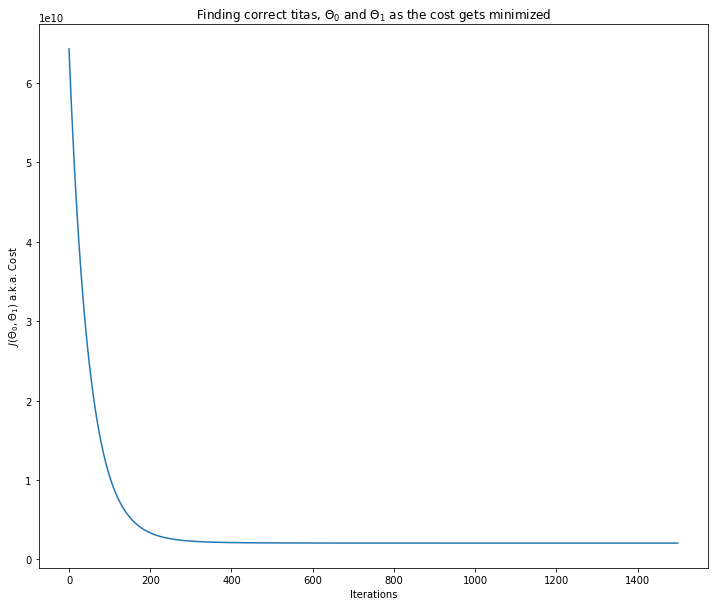

In [20]:
plt.figure(figsize=(12,10))
plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("$ J(\Theta_0, \Theta_1) $ a.k.a. Cost")
plt.title("Finding correct titas, $ \Theta_0 $ and $ \Theta_1 $ as the cost gets minimized")

In [21]:
model = LinearRegression(normalize=True, copy_X=True).fit(X, y)
float(model.predict(np.array([[1650, 3]])))

293081.4643348962

In [25]:
model.intercept_, model.coef_
np.hstack([[model.intercept_], model.coef_])

array([[89597.9095428 ,   139.21067402, -8738.01911233]])

[&lt;matplotlib.lines.Line2D at 0x7f826b832820&gt;]

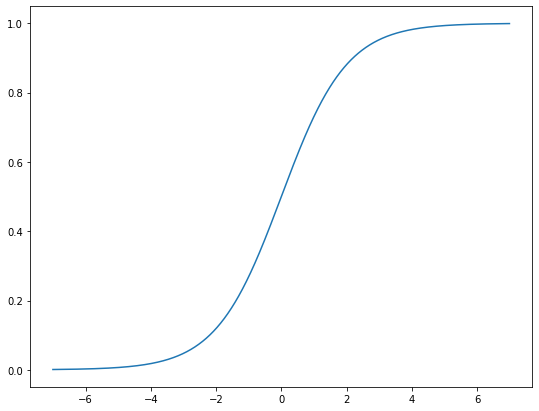

In [23]:
x = np.arange(-7, 7, 0.01)
y = 1 / (1 + np.exp(-x))

plt.figure(figsize=(9,7))
plt.plot(x, y)

[&lt;matplotlib.lines.Line2D at 0x7f826b3488e0&gt;]

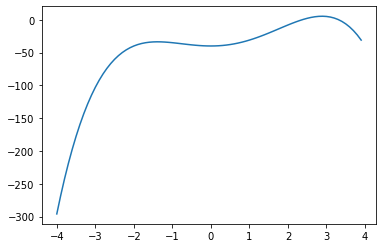

In [24]:
x = np.arange(-4, 4, 0.1)
y = -x**4 + 2*x**3 + 8*x**2 - 40
plt.plot(x, y)